In [22]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [23]:
df = pd.read_csv('hw_aa.csv',
                 sep       = ";", 
                 index_col = 0)
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


<AxesSubplot: >

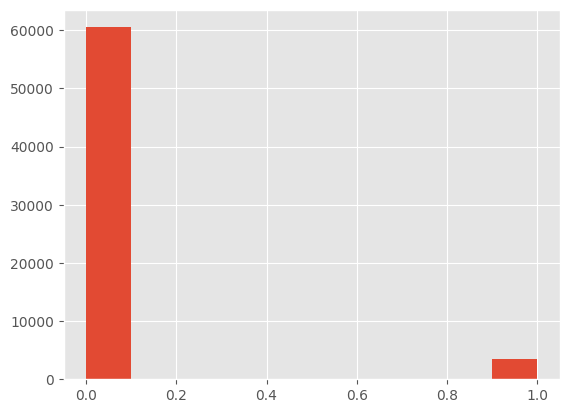

In [24]:
exp0 = df.query('experimentVariant == 0')[['version', 'purchase']]
exp1 = df.query('experimentVariant == 1')[['version', 'purchase']]
exp1.purchase.hist()

<AxesSubplot: >

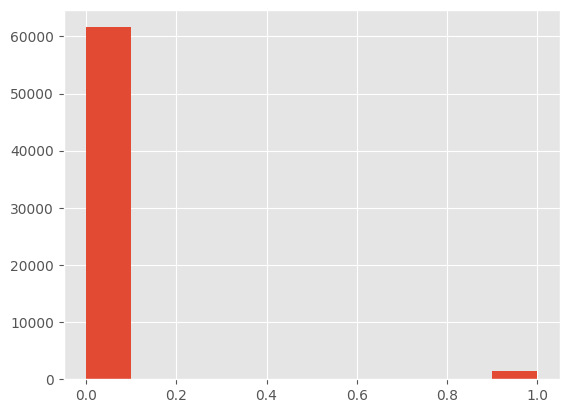

In [25]:
exp0.purchase.hist()
#похожи

In [26]:
def aatest(coldata1, coldata2):
    n = 100000
    simulations = 1000
    n_s = 1000
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = coldata1.sample(n_s, replace = False).values
        s2 = coldata2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    
    # Проверяем, что количество ложноположительных случаев не превышает альфа
    return sum(np.array(res) <0.05) / simulations

  0%|          | 0/1000 [00:00<?, ?it/s]

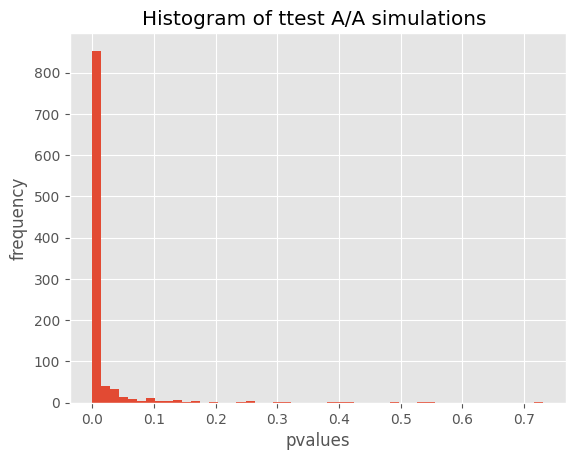

0.933

In [27]:
aatest(exp0.purchase, exp1.purchase)
# всё плохо

In [28]:
df0 = exp0.groupby(['version'], 
                   as_index = False) \
          .agg({'purchase' : {'mean', 
                              'count'}}) \
          .rename(columns = {'purchase' : 'purchase0'})

df1 = exp1.groupby(['version'], 
                   as_index = False) \
          .agg({'purchase' : {'mean',
                              'count'}}) \
          .rename(columns = {'purchase' : 'purchase1'})

vp = df0.merge(df1, 
               how = 'inner', 
               on  = 'version')
vp
#явно видно, что нужно выкинуть v2.8.0 из-за большой разницы в конверсии(почти в 50 раз)

/tmp/.private/di0gen/ipykernel_183827/2311226082.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  vp = df0.merge(df1,


version purchase0           purchase1          
                count      mean     count      mean
0    v2.8.0     41283  0.000993     41552  0.045606
1    v2.9.0     11921  0.074658     12033  0.071304
2  v3.7.4.0      4204  0.059943      4221  0.063018
3  v3.8.0.0      5694  0.057604      6110  0.062848

  0%|          | 0/1000 [00:00<?, ?it/s]

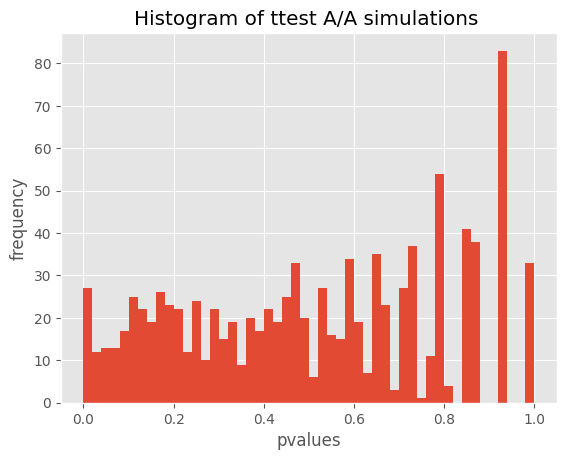

0.045

In [29]:
aatest(exp0.query('version != "v2.8.0"').purchase, exp1.query('version != "v2.8.0"').purchase)
# теперь отлично

In [30]:
losedf = exp0.groupby(['version'], 
                      as_index = False) \
             .agg({'purchase' : 'mean'}) \
             .rename(columns = {'purchase' : 'purchase0'}) \
             .merge(exp1.groupby(['version'], 
                                 as_index = False) \
                        .agg({'purchase' : 'mean'}) \
                        .rename(columns = {'purchase':'purchase1'}), 
                    how = 'inner', 
                    on  = 'version'
                   )
losedf

,version,purchase0,purchase1
0,v2.8.0,0.000993,0.045606
1,v2.9.0,0.074658,0.071304
2,v3.7.4.0,0.059943,0.063018
3,v3.8.0.0,0.057604,0.062848
